In [121]:
from models.ICA_EM import *
from models.dgp import *
from models.metrics import *
import importlib, sys
importlib.reload(sys.modules['models.ICA_EM'])
importlib.reload(sys.modules['models.dgp'])
importlib.reload(sys.modules['models.metrics'])
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [106]:
def norm_funtion(A):
    # [0,0], [1,1] must be one
    A_0 = A[:, 0]/A[0,0]
    return A_0

In [122]:
class CausalVarEM(VarEM):
    def __init__(self, update_sigma=False, true_A=None, tol=1e-4, **kwargs):
        super().__init__(update_sigma=update_sigma, true_A=true_A, tol=tol, **kwargs)
    
    def update_A(self): # we can force causal structure 
        temp1 = np.zeros((self.I, self.J))
        temp2 = np.zeros((self.J, self.J))
 
        
        for i in range(self.n):
            omega_i = self._omega_mat(i)
            M_i = self._M_mat(omega_i)
            x_outer = np.outer(self.X[i,:], self.X[i,:])
            temp1 += x_outer @ M_i.T @ self.A @ omega_i
            temp2 += omega_i @ (np.eye(self.J) - self.A.T @ M_i @ (np.eye(self.I) - x_outer @ M_i.T) @ self.A @ omega_i)
            self._update_xi(i, M_i, omega_i, x_outer)
        A_new = temp1 @ np.linalg.inv(temp2)
        if self.update_sigma:
            self._update_sigma(A_new)


        # calculate the difference between the old and new A
        diff = np.linalg.norm(self.A - A_new, ord='fro')
        self.A = A_new
        return diff
    
    def _initilize_A(self):
        super()._initilize_A()
        self.A[0,1] = 0
        # set ones
        
        self.A[0,0] = 1
        self.A[1,1] = 1
        # set controls to 1
        for j in range(2, self.J-1):
            self.A[j,j+1] = 1
            



In [123]:
# compare VarEM with CausalVarEM
n = 10000
J = 6
I = J-1
treatmet_true = []
treatment_var_perm= []
treatment_causal_perm = []
score_var = []
score_causal = []
treatment_var_first_column = []
treatment_causal_first_column = []
mse_var = []
mse_causal = []
likelihood_score_var = []
likelihood_score_causal = []

data = dgp(prior={"loc" : 0, "scale" : 1/np.sqrt(2)} ,noise_dict={"loc" : 0, "scale" : 1})

for i in tqdm.tqdm(range(100)):
    data.generate_data(n=n, J=J, I=I, random_state=i)
    estimator = VarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=i)
    estimator.fit(data.data_observed, J = J, progress_bar=False)
    best_perm, score = f_score(data.mixing_matrix_observed, estimator.A)    
    score_var.append(score)
    treatment_var_perm.append(norm_funtion(estimator.A[:, best_perm])[1])
    treatment_var_first_column.append(norm_funtion(estimator.A)[1])
    mse_var.append(mean_squared_error(data.signals, estimator.Signals[:, best_perm]))
    likelihood_score_var.append(likelihood_score(data.signals, estimator.Signals[:, best_perm]))


    estimator_Causal = CausalVarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=i)
    estimator_Causal.fit(data.data_observed, J = J, progress_bar=False)
    best_perm, score = f_score(data.mixing_matrix_observed, estimator_Causal.A)    
    score_causal.append(score)
    treatmet_true.append(data.treatment_effect)
    treatment_causal_perm.append(norm_funtion(estimator_Causal.A[:,best_perm])[1])
    treatment_causal_first_column.append(norm_funtion(estimator_Causal.A)[1])
    mse_causal.append(mean_squared_error(data.signals, estimator_Causal.Signals[:, best_perm]))
    likelihood_score_causal.append(likelihood_score(data.signals, estimator_Causal.Signals[:, best_perm]))


 57%|█████▋    | 57/100 [2:01:49<1:53:21, 158.18s/it]

In [ ]:
# save results
results = pd.DataFrame({"treatment_true" : treatmet_true, 
                        "treatment_var_perm" : treatment_var_perm, 
                        "treatment_var_first_column" : treatment_var_first_column, 
                        "treatment_causal_perm" : treatment_causal_perm,
                          "treatment_causal_first_column" : treatment_causal_first_column,
                            "score_var" : score_var,
                              "score_causal" : score_causal,
                                "mse_var" : mse_var,
                                  "mse_causal" : mse_causal,
                                    "likelihood_score_var" : likelihood_score_var,
                                      "likelihood_score_causal" : likelihood_score_causal})
results.to_csv("results_var_vs_causal.csv", index = False)

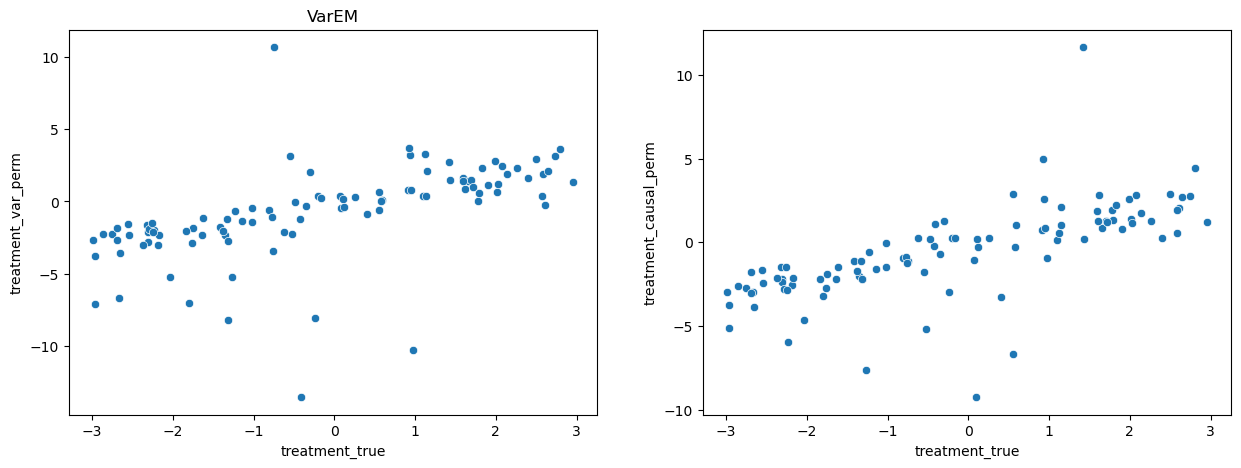

7.227191061599829
4.332024629942244


In [14]:
from sklearn.metrics import mean_squared_error
results = pd.read_csv("results_var_vs_causal.csv")
fig, ax = plt.subplots(1,2,figsize = (15,5)) 
sns.scatterplot(x=results.treatment_true, y=results.treatment_var_perm, ax = ax[0])
ax[0].title.set_text('VarEM')
sns.scatterplot(x=results.treatment_true, y=results.treatment_causal_perm, ax = ax[1])
ax[1].title.set_text('CausalVarEM')
plt.show()
print(mean_squared_error(results.treatment_true, results.treatment_var_perm))
print(mean_squared_error(results.treatment_true, results.treatment_causal_perm))

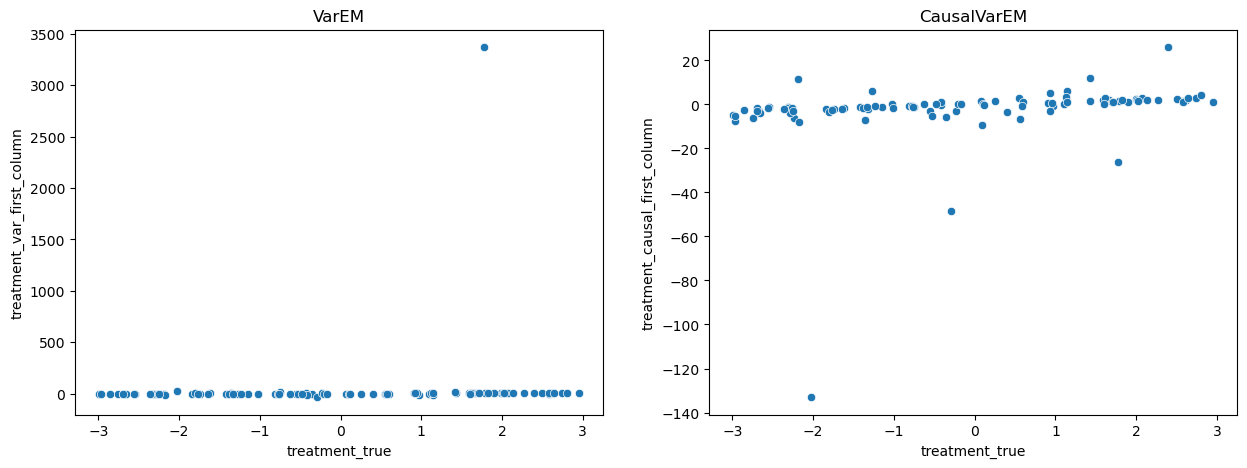

113459.66908495763
216.2025737018272


In [15]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
sns.scatterplot(x=results.treatment_true, y=results.treatment_var_first_column, ax = ax[0])
ax[0].title.set_text('VarEM')
sns.scatterplot(x=results.treatment_true, y=results.treatment_causal_first_column, ax = ax[1])
ax[1].title.set_text('CausalVarEM')
plt.show()  
print(mean_squared_error(results.treatment_true, results.treatment_var_first_column))
print(mean_squared_error(results.treatment_true, results.treatment_causal_first_column))


In [17]:
ind_varEM = np.argmax(results.treatment_var_first_column)
ind_causal = np.argmin(results.treatment_causal_first_column)

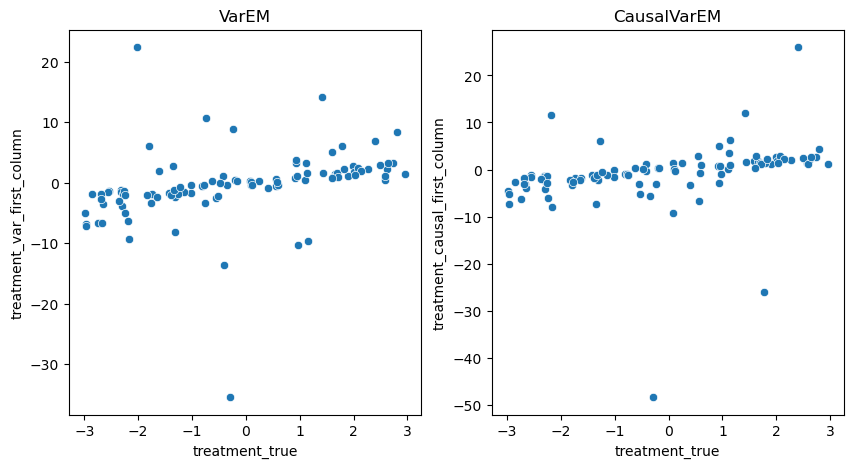

30.800336812791844
44.99373090797746


In [22]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
sns.scatterplot(x=results.treatment_true.drop(ind_varEM), y=results.treatment_var_first_column.drop(ind_varEM), ax=ax[0])
ax[0].title.set_text('VarEM')
sns.scatterplot(x =results.treatment_true.drop(ind_causal), y = results.treatment_causal_first_column.drop(ind_causal), ax = ax[1])
ax[1].title.set_text('CausalVarEM')
plt.show()
print(mean_squared_error(results.treatment_true.drop(ind_varEM), results.treatment_var_first_column.drop(ind_varEM)))
print(mean_squared_error(results.treatment_true.drop(ind_causal), results.treatment_causal_first_column.drop(ind_causal)))

In [85]:
# plot signals righltly ordered
data = dgp(prior={"loc" : 0, "scale" : 1}, noise_dict=  {"loc" : 0, "scale" : 1})
data.generate_data(n=n, J=J, I=I, random_state=10)
VarEM_est= VarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=1)
VarEM_est.fit(data.data_observed, J = J,
                      noise_params= {"mean" : 0, "std" : 1})
CausalVarEM_est = CausalVarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=1)
CausalVarEM_est.fit(data.data_observed, J = J,
                      noise_params= {"mean" : 0, "std" : 1})



Adding noise
Initializing A with true A + noise


Diff: 0.0021: 100%|██████████| 200/200 [00:44<00:00,  4.50it/s]


Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91611.29it/s]


Initializing A with true A + noise


Diff: 0.0032: 100%|██████████| 200/200 [00:46<00:00,  4.32it/s]


Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 73859.63it/s]


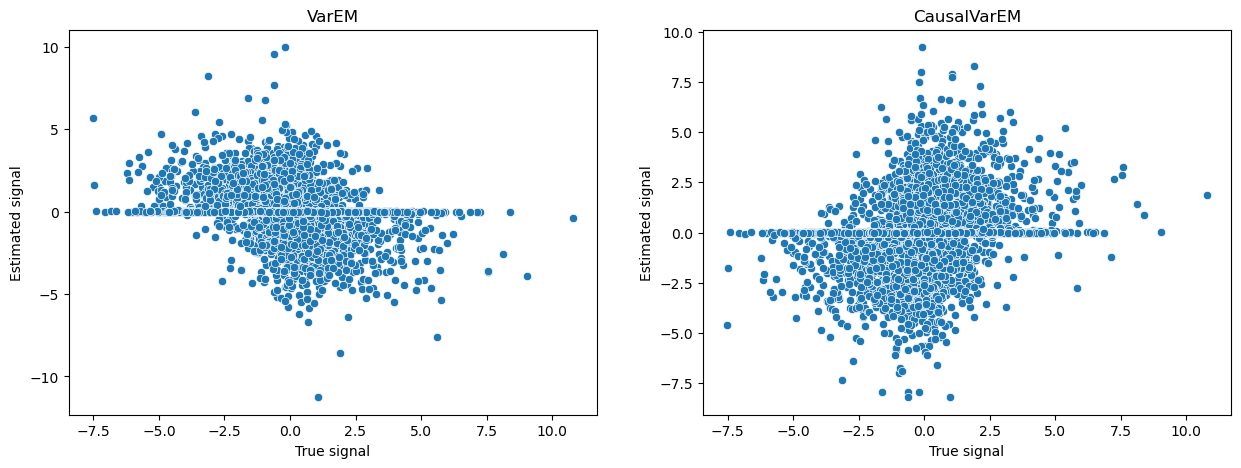

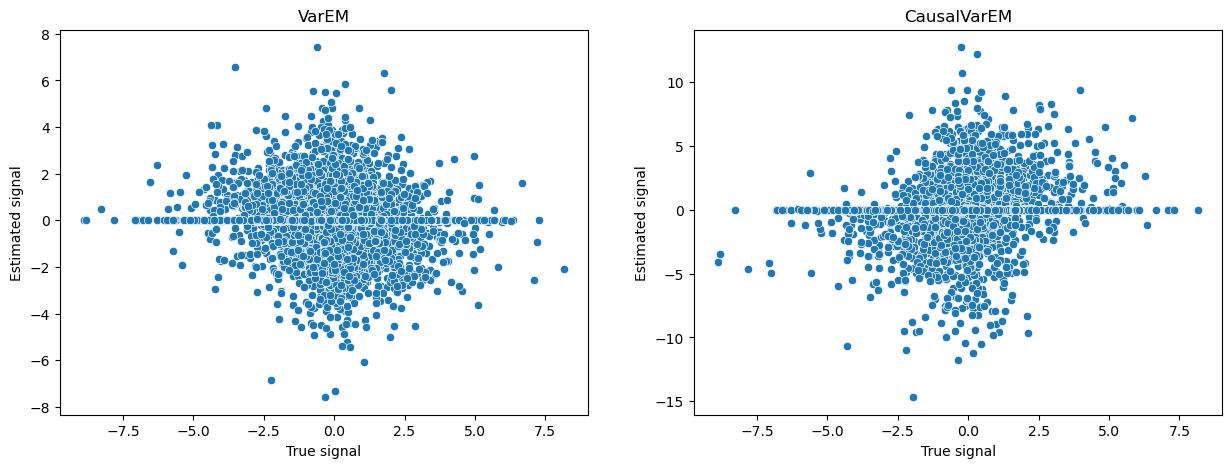

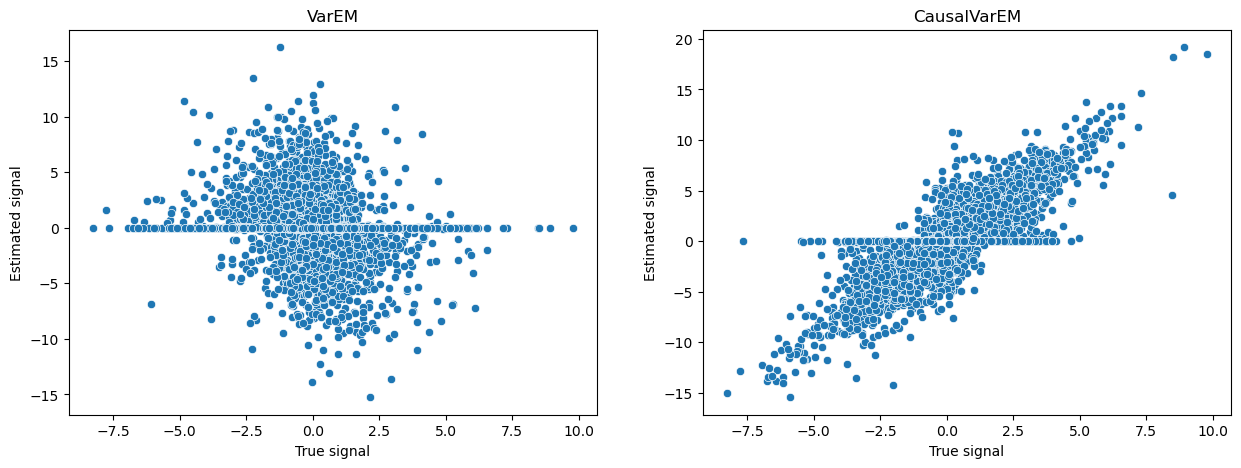

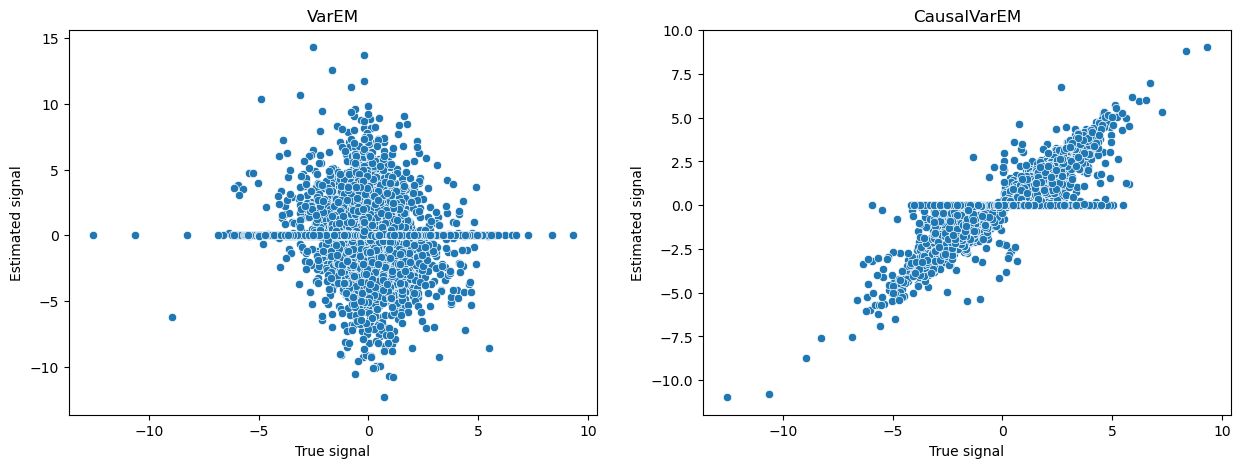

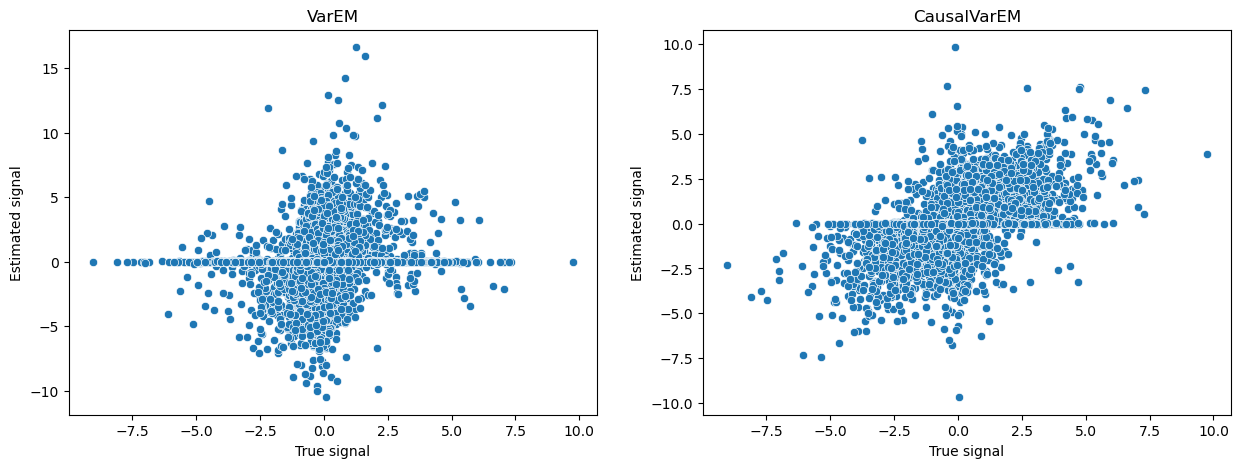

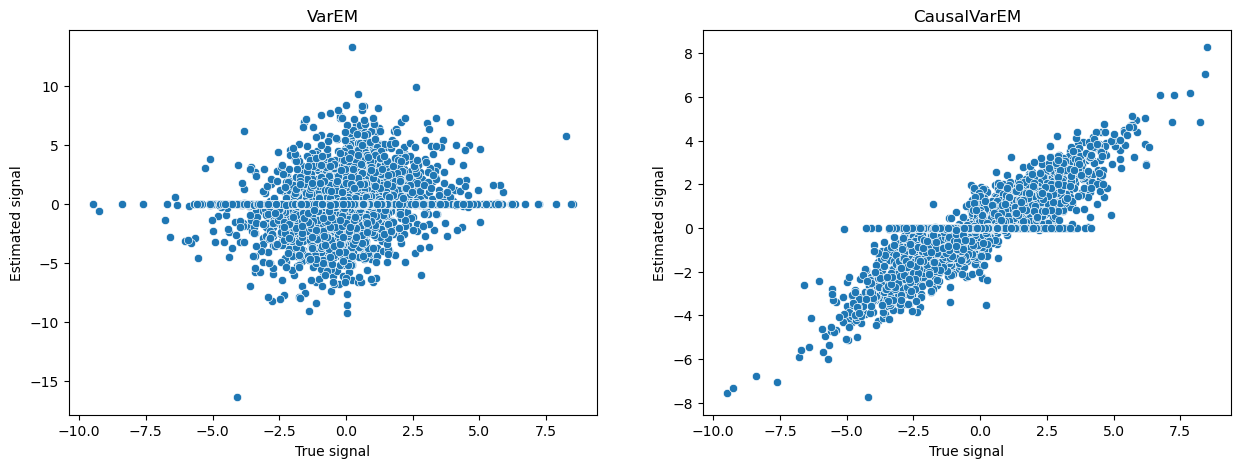

In [88]:
best_perm_var, score = f_score(data.mixing_matrix_observed, VarEM_est.A)
singals_estimation_VAR = VarEM_est.Signals[:,best_perm]
best_perm_causal, score = f_score(data.mixing_matrix_observed, CausalVarEM_est.A)
singals_estimation_Causal = CausalVarEM_est.Signals[:,best_perm_causal]
for i in range(J):
    fig, ax = plt.subplots(1,2,figsize = (15,5))
    sns.scatterplot(x = data.signals[:,i], y = singals_estimation_VAR[:,i], ax = ax[0])
    ax[0].title.set_text('VarEM')
    ax[0].set_xlabel('True signal')
    ax[0].set_ylabel('Estimated signal')
    sns.scatterplot(x = data.signals[:,i], y = singals_estimation_Causal[:,i], ax = ax[1])
    ax[1].title.set_text('CausalVarEM')
    ax[1].set_xlabel('True signal')
    ax[1].set_ylabel('Estimated signal')
    plt.show()
    